In [34]:
import pandas as pd
import numpy as np
import keras
from keras.layers import Dense, Input, LSTM, concatenate, Embedding
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
import os
import csv
from datetime import datetime
from log import _check_log_directory,_initialise_model_log

In [2]:
data_dir = "./data"
log_dir = './log'

In [26]:
# Glove features
features_train = pd.read_csv(os.path.join(data_dir,'train_features_glove.csv'), sep=',', encoding='latin-1')
features_test = pd.read_csv(os.path.join(data_dir,'test_features_glove.csv'), sep=',', encoding='latin-1')
features_train= features_train.drop(['question1', 'question2'], axis=1)
features_test = features_test.drop(['id','qid1','qid2','question1', 'question2'], axis=1)
data_train = pd.read_csv('./data/train.csv', sep=',',names = ["id", "qid1", "qid2", "question1","question2","is_duplicate"])
Y_train=data_train["is_duplicate"].values

# Pagerank features
pagerank_feats_train = pd.read_csv(os.path.join(data_dir,"train_pagerank.csv"), sep=',')
pagerank_feats_test = pd.read_csv(os.path.join(data_dir,"test_pagerank.csv"), sep=',')

# Question frequency
train_question_freq = pd.read_csv(os.path.join(data_dir,'train_question_freq.csv'), sep=',', index_col=0)
test_question_freq = pd.read_csv(os.path.join(data_dir,'test_question_freq.csv'), sep=',', index_col=0)

# Intersection of questions
train_question_inter= pd.read_csv(os.path.join(data_dir,'train_question_inter.csv'), sep=',', index_col=0)
test_question_inter = pd.read_csv(os.path.join(data_dir,'test_question_inter.csv'), sep=',', index_col=0)

# K-cores
train_kcores = pd.read_csv(os.path.join(data_dir,'train_kcores.csv'), sep=',', index_col=0)
test_kcores = pd.read_csv(os.path.join(data_dir,'test_kcores.csv'), sep=',', index_col=0)

# question K-cores
train_question_kcores = pd.read_csv(os.path.join(data_dir,'train_question_kcores.csv'), sep=',', index_col=0)
test_question_kcores = pd.read_csv(os.path.join(data_dir,'test_question_kcores.csv'), sep=',', index_col=0)

# TF-IDF
train_tfidf = pd.read_csv(os.path.join(data_dir,'train_tfidf.csv'), sep=',', index_col=0)
test_tfidf = pd.read_csv(os.path.join(data_dir,'test_tfidf.csv'), sep=',', index_col=0)

# Graph features
train_graph_feat = pd.read_csv(os.path.join(data_dir,'train_graph_feat.csv'), sep=',', index_col=0)
test_graph_feat = pd.read_csv(os.path.join(data_dir,'test_graph_feat.csv'), sep=',', index_col=0)

# Bigram feature
train_bigram_feat = pd.read_csv(os.path.join(data_dir,'train_bigram_feat.csv'), sep=',', index_col=0)
test_bigram_feat = pd.read_csv(os.path.join(data_dir,'test_bigram_feat.csv'), sep=',', index_col=0)

In [27]:
# Add Pagerank features
features_train[["q1_pr","q2_pr"]]=pagerank_feats_train[["q1_pr","q2_pr"]]
features_test[["q1_pr","q2_pr"]]=pagerank_feats_test[["q1_pr","q2_pr"]]

# Add question frequency features
features_train[["q1_hash","q2_hash","q1_freq","q2_freq"]]=train_question_freq[["q1_hash","q2_hash","q1_freq","q2_freq"]]
features_test[["q1_hash","q2_hash","q1_freq","q2_freq"]]=test_question_freq[["q1_hash","q2_hash","q1_freq","q2_freq"]]

# Add intersection of questions features
features_train['q1_q2_intersect']=train_question_inter['q1_q2_intersect']
features_test['q1_q2_intersect']=test_question_inter['q1_q2_intersect']

# Add K-cores
features_train[["core1","core2","core3"]] = train_kcores[["core1","core2","core3"]]
features_test[["core1","core2","core3"]] = test_kcores[["core1","core2","core3"]]

# Add question K-cores features
features_train[['q1_kcores', 'q2_kcores', 'q1_q2_kcores_ratio', 'q1_q2_kcores_diff', 
                'q1_q2_kcores_diff_normed']]=train_question_kcores[['q1_kcores', 'q2_kcores', 'q1_q2_kcores_ratio', 'q1_q2_kcores_diff', 'q1_q2_kcores_diff_normed']]
features_test[['q1_kcores', 'q2_kcores', 'q1_q2_kcores_ratio', 'q1_q2_kcores_diff', 
               'q1_q2_kcores_diff_normed']]=test_question_kcores[['q1_kcores', 'q2_kcores', 'q1_q2_kcores_ratio', 'q1_q2_kcores_diff', 'q1_q2_kcores_diff_normed']]

# Add TF-IDF features
features_train[['word_match','tfidf_wm','tfidf_wm_stops','jaccard','wc_diff','wc_ratio','wc_diff_unique','wc_ratio_unique','wc_diff_unq_stop','wc_ratio_unique_stop','same_start',
 'char_diff','char_diff_unq_stop','total_unique_words','total_unq_words_stop','char_ratio']]=train_tfidf[['word_match','tfidf_wm','tfidf_wm_stops','jaccard','wc_diff','wc_ratio','wc_diff_unique','wc_ratio_unique','wc_diff_unq_stop','wc_ratio_unique_stop','same_start',
 'char_diff','char_diff_unq_stop','total_unique_words','total_unq_words_stop','char_ratio']]
features_test[['word_match','tfidf_wm','tfidf_wm_stops','jaccard','wc_diff','wc_ratio','wc_diff_unique','wc_ratio_unique','wc_diff_unq_stop','wc_ratio_unique_stop','same_start',
 'char_diff','char_diff_unq_stop','total_unique_words','total_unq_words_stop','char_ratio']]=test_tfidf[['word_match','tfidf_wm','tfidf_wm_stops','jaccard','wc_diff','wc_ratio','wc_diff_unique','wc_ratio_unique','wc_diff_unq_stop','wc_ratio_unique_stop','same_start',
 'char_diff','char_diff_unq_stop','total_unique_words','total_unq_words_stop','char_ratio']]

# Add graph features
features_train[['q1_neigh','q2_neigh','common_neigh', 'distinct_neigh', 'clique_size']] = train_graph_feat[['q1_neigh','q2_neigh','common_neigh', 'distinct_neigh', 'clique_size']]
features_test[['q1_neigh','q2_neigh','common_neigh', 'distinct_neigh', 'clique_size']] = test_graph_feat[['q1_neigh','q2_neigh','common_neigh', 'distinct_neigh', 'clique_size']]

# Add bigram features
features_train[['bigram_coocurence','bigram_distinct','bigram_nostpwrd_coocurence', 'bigram_nostpwrd_distinct']] = train_bigram_feat[['bigram_coocurence','bigram_distinct','bigram_nostpwrd_coocurence', 'bigram_nostpwrd_distinct']]
features_test[['bigram_coocurence','bigram_distinct','bigram_nostpwrd_coocurence', 'bigram_nostpwrd_distinct']] = test_bigram_feat[['bigram_coocurence','bigram_distinct','bigram_nostpwrd_coocurence', 'bigram_nostpwrd_distinct']]


In [31]:
X = features_train
X_test = features_test
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(value=0)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(value=0)

In [32]:
X.columns

Index([                 u'is_duplicate',                        u'len_q1',
                              u'len_q2',                      u'diff_len',
                         u'len_char_q1',                   u'len_char_q2',
                         u'len_word_q1',                   u'len_word_q2',
                        u'common_words',                   u'fuzz_qratio',
                         u'fuzz_WRatio',            u'fuzz_partial_ratio',
        u'fuzz_partial_token_set_ratio', u'fuzz_partial_token_sort_ratio',
                u'fuzz_token_set_ratio',         u'fuzz_token_sort_ratio',
                                 u'wmd',                      u'norm_wmd',
                     u'cosine_distance',            u'cityblock_distance',
                    u'jaccard_distance',             u'canberra_distance',
                  u'euclidean_distance',            u'minkowski_distance',
                 u'braycurtis_distance',                    u'skew_q1vec',
                         

In [33]:
data = X
Y = data.pop('is_duplicate')
test_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(data, Y, test_size=test_size)
del data
gc.collect()

905

In [39]:
print "number of features =", X_train.values.shape[1]

number of features = 68


In [80]:
X_train_np = X_train.values
X_val_np = X_val.values
Y_train_np = Y_train.values
Y_val_np  = Y_val.values

shape = (X_train_np.shape[1],)
model = Sequential()
model.add(Dense(1024, activation='sigmoid',input_shape=shape))
model.add(Dense(1,activation = "sigmoid"))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt)
history = model.fit(X_train_np,Y_train_np,epochs=20,validation_data =(X_val_np,Y_val_np))

Train on 72090 samples, validate on 8010 samples
Epoch 1/20
72090/72090 [==============================] - 15s 206us/step - loss: 0.5816 - val_loss: 0.5462
Epoch 2/20
72090/72090 [==============================] - 14s 198us/step - loss: 0.5027 - val_loss: 0.4684
Epoch 3/20
72090/72090 [==============================] - 13s 175us/step - loss: 0.4251 - val_loss: 0.4062
Epoch 4/20
72090/72090 [==============================] - 11s 150us/step - loss: 0.3623 - val_loss: 0.3653
Epoch 5/20
72090/72090 [==============================] - 9s 122us/step - loss: 0.3232 - val_loss: 0.3619
Epoch 6/20
72090/72090 [==============================] - 9s 118us/step - loss: 0.3108 - val_loss: 0.2913
Epoch 7/20
72090/72090 [==============================] - 7s 104us/step - loss: 0.2927 - val_loss: 0.2777
Epoch 8/20
72090/72090 [==============================] - 9s 118us/step - loss: 0.2828 - val_loss: 0.2756
Epoch 9/20
72090/72090 [==============================] - 10s 132us/step - loss: 0.2843 - val_loss:

In [81]:
opt = keras.optimizers.Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=opt)
history2 = model.fit(X_train_np,Y_train_np,epochs=15,validation_data =(X_val_np,Y_val_np))

Train on 72090 samples, validate on 8010 samples
Epoch 1/15
72090/72090 [==============================] - 10s 142us/step - loss: 0.2353 - val_loss: 0.2438
Epoch 2/15
72090/72090 [==============================] - 9s 120us/step - loss: 0.2329 - val_loss: 0.2411
Epoch 3/15
72090/72090 [==============================] - 9s 123us/step - loss: 0.2298 - val_loss: 0.2382
Epoch 4/15
72090/72090 [==============================] - 9s 120us/step - loss: 0.2284 - val_loss: 0.2381
Epoch 5/15
72090/72090 [==============================] - 9s 123us/step - loss: 0.2286 - val_loss: 0.2404
Epoch 6/15
72090/72090 [==============================] - 8s 117us/step - loss: 0.2290 - val_loss: 0.2386
Epoch 7/15
72090/72090 [==============================] - 8s 116us/step - loss: 0.2280 - val_loss: 0.2350
Epoch 8/15
72090/72090 [==============================] - 8s 115us/step - loss: 0.2257 - val_loss: 0.2364
Epoch 9/15
72090/72090 [==============================] - 8s 116us/step - loss: 0.2246 - val_loss: 0.2

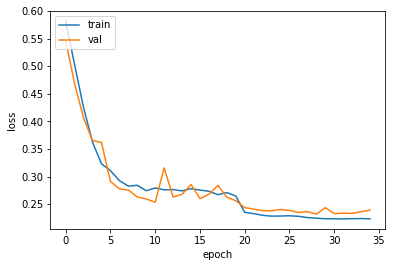

In [84]:
plt.plot(history.history["loss"]+ history2.history["loss"])
plt.plot(history.history["val_loss"]+ history2.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
## Apres ici ce sont des tests

# Calcul de la taille maximale des questions

In [20]:
q1_train = data_train["question1"]
q2_train = data_train["question2"]
q1_test = data_test["question1"]
q2_test = data_test["question2"]

In [21]:
q1_train_sp = [q.split() for q in q1_train]
q2_train_sp = [q.split() for q in q2_train]
q1_test_sp = [q.split() for q in q1_test]
q2_test_sp = [q.split() for q in q2_test]

In [22]:
print max([len(q) for q in q1_train_sp])
print max([len(q) for q in q2_train_sp])
print max([len(q) for q in q1_test_sp])
Tprint max([len(q) for q in q2_test_sp])

65
58
73
49


In [ ]:
max_size = 73

# Load features 

In [33]:
features_train = pd.read_csv('data/train_features_glove.csv', sep=',', encoding='latin-1')
features_test = pd.read_csv('data/test_features_glove.csv', sep=',', encoding='latin-1')
data_train = pd.read_csv('train.csv', sep=',',names = ["id", "qid1", "qid2", "question1","question2","is_duplicate"])
Y = data_train.pop("is_duplicate")

In [34]:
X = features_train
X_test = features_test
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(value=0)
X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(value=0)

In [35]:
data = X
#data.pop("question1")
#data.pop("question2")
#data.pop("is_duplicate")
X_train= features_train.drop(['question1','question2','is_duplicate','cosine_distance','jaccard_distance','euclidean_distance','norm_wmd','fuzz_WRatio','len_word_q2','len_word_q1','minkowski_distance','braycurtis_distance'], axis=1)
test_size = 0.1
X_train, X_val, Y_train, Y_val = train_test_split(data, Y, test_size=test_size)
del data
gc.collect()

45

In [39]:
import keras
X_train_np = X_train.values
X_val_np = X_val.values
Y_train_np = Y_train.values
Y_val_np  = Y_val.values

shape = (X_train_np.shape[1],)
model = Sequential()
model.add(Dense(1024, activation='sigmoid',input_shape=shape))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(1024, activation='sigmoid'))
#model.add(Dense(1024, activation='tanh'))
model.add(Dense(1,activation = "sigmoid"))
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer="adam")
model.fit(X_train_np,Y_train_np,nb_epoch=10,validation_data =(X_val_np,Y_val_np))

Train on 72090 samples, validate on 8010 samples
Epoch 1/10
72090/72090 [==============================] - 273s 4ms/step - loss: 0.5719 - val_loss: 0.5572
Epoch 2/10
72090/72090 [==============================] - 162s 2ms/step - loss: 0.5489 - val_loss: 0.5507
Epoch 3/10
72090/72090 [==============================] - 157s 2ms/step - loss: 0.5407 - val_loss: 0.5414
Epoch 4/10
72090/72090 [==============================] - 157s 2ms/step - loss: 0.5368 - val_loss: 0.5550
Epoch 5/10
72090/72090 [==============================] - 158s 2ms/step - loss: 0.5318 - val_loss: 0.5314
Epoch 6/10
72090/72090 [==============================] - 169s 2ms/step - loss: 0.5290 - val_loss: 0.5328
Epoch 7/10
72090/72090 [==============================] - 288s 4ms/step - loss: 0.5247 - val_loss: 0.5434
Epoch 8/10
72090/72090 [==============================] - 358s 5ms/step - loss: 0.5230 - val_loss: 0.5263
Epoch 9/10
72090/72090 [==============================] - 414s 6ms/step - loss: 0.5204 - val_loss: 0.53

In [37]:
X_train.head()

,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzz_qratio,fuzz_WRatio,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
61470,30,26,4,15,13,6,5,2,67,70,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-5.397956,-5.397956,50.999782,50.999782
52652,115,39,76,23,16,25,9,6,38,86,...,6.248636,1.0,157.564608,0.454233,0.206826,0.378103,-7.113229,-4.746818,65.892186,38.016010
62647,104,99,5,23,27,16,16,6,62,62,...,6.700246,1.0,160.466555,0.477150,0.213258,0.390585,-5.871459,-4.239369,46.448806,28.991935
605,38,42,-4,15,16,7,7,3,79,79,...,11.052061,1.0,166.510503,0.815223,0.377213,0.485439,-0.580091,-2.302947,1.765170,14.246697
5464,43,35,8,20,16,8,7,2,58,58,...,8.190089,1.0,153.197744,0.605530,0.279310,0.394413,-3.854237,-2.359391,31.850361,19.318841


In [30]:
X_train.head()

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,...,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance,skew_q1vec,skew_q2vec,kur_q1vec,kur_q2vec
19866,What is a good way to spend a long weekend in ...,What is the best way to spend a weekend in Ban...,1,67,53,14,20,20,14,11,...,3.778034,1.0,128.590874,0.273035,0.124839,0.236917,-6.923558,-6.190262,63.793805,53.960178
38013,What does it mean if a dog vomits white foam?,What does it mean if a dog is throwing up yell...,1,45,77,-32,16,23,10,17,...,6.219466,1.0,147.157158,0.445947,0.200436,0.341283,-3.553175,-4.978099,25.958704,42.166227
60509,How can you make your skin lighter?,What can I do to make my skin whiter?,1,35,37,-2,19,18,7,9,...,6.720695,1.0,137.431993,0.473985,0.210055,0.325232,-4.250795,-2.831428,34.080928,20.905081
73053,What is the best passive investment strategy?,What is your investment strategy?,0,45,33,12,16,16,7,5,...,5.982412,1.0,137.046347,0.435726,0.200231,0.304307,-5.354166,-3.369078,46.089431,23.742220
56738,What is the best way to start learning program...,How do I start learning programming language? ...,1,71,70,1,21,21,12,12,...,4.675204,1.0,143.059820,0.340347,0.155126,0.297584,-6.921454,-6.508542,65.565907,58.963952
